# Portfolio Optimization

### Averaging uncorrelated random variables reduces variance!

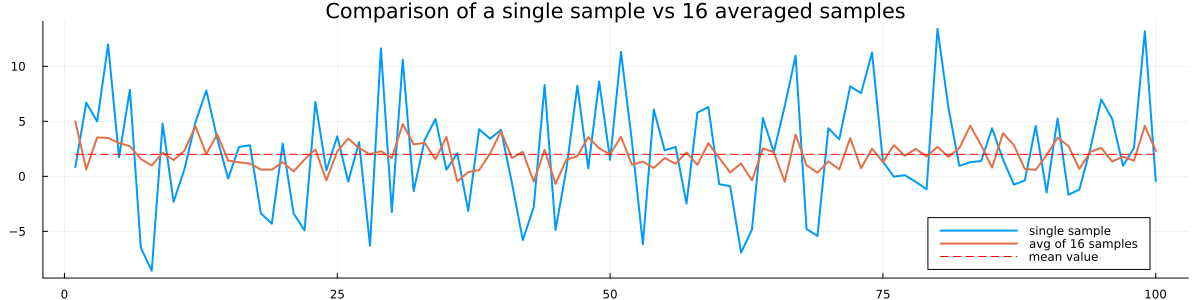

In [3]:
using Random, Statistics, Plots

Random.seed!(0)

X = 2.0 .+ 5.0*randn(100,16)

# Prepare data
x_vals = 1:100
single_sample = X[:, 1]
averaged_sample = mean(X, dims=2)[:]
mean_value = fill(2.0, 100)

# Plot
plot(x_vals, single_sample, label="single sample", linewidth=2, size=(1200, 300))
plot!(x_vals, averaged_sample, label="avg of 16 samples", linewidth=2)
plot!(x_vals, mean_value, label="mean value", linestyle=:dash, color=:red)
title!("Comparison of a single sample vs 16 averaged samples")



# Portfolio optimization example

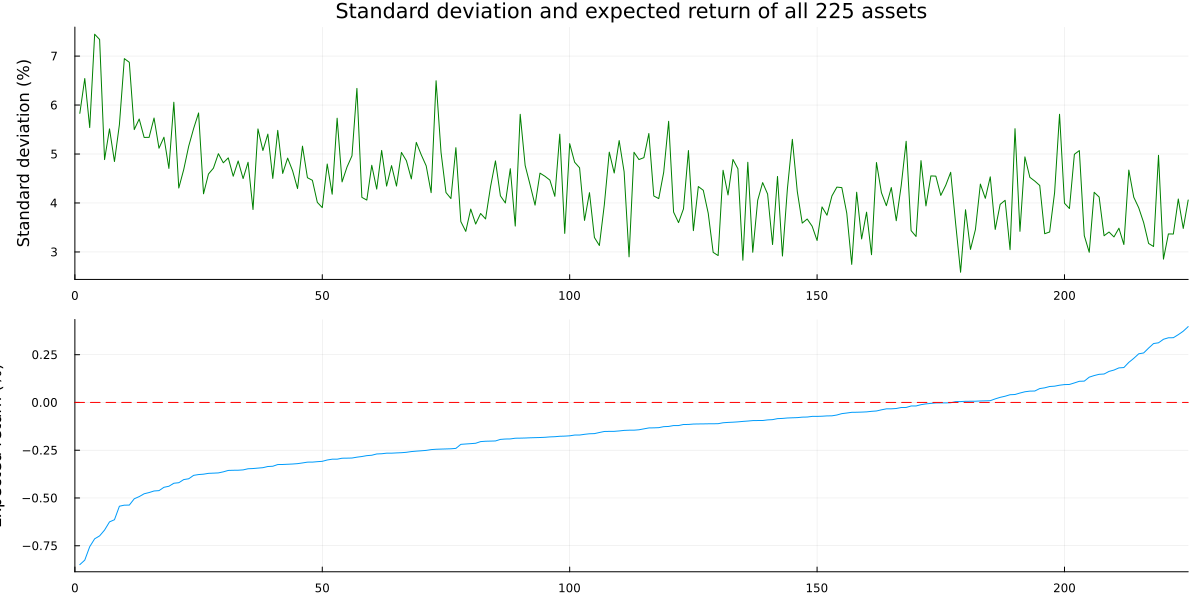

In [4]:
using CSV, LinearAlgebra, DataFrames, NamedArrays

μ_read = CSV.read("folio_mean.csv", header = false,DataFrame)  # Expected return (in percent)
(n,m) = size(μ_read)
μ = 100*Vector(μ_read[1:n,1]) 

Σ_read = CSV.read("folio_cov.csv", header=false,DataFrame)   # Expected variance (in percent squared)
(k,l) = size(Σ_read)
Σ = 10000*Matrix(Σ_read[1:l,1:k])

# source code resumes..

ix = sortperm(μ);   # get order of indices which will sort the assets by expected return

# Extract data
std_devs = sqrt.(diag(Σ))[ix]
expected_returns = μ[ix]

# Plot
plot(
    layout = (2, 1),
    size = (1200, 600)
)

# Top subplot: standard deviations
plot!(
    std_devs,
    color = :green,
    label = "",
    xlim = (0, 225),
    ylabel = "Standard deviation (%)",
    title = "Standard deviation and expected return of all 225 assets",
    subplot = 1,
)

# Bottom subplot: expected returns
plot!(
    expected_returns,
    label = "",
    xlim = (0, 225),
    ylabel = "Expected return (%)",
    subplot = 2,
)

# Add red dashed line at y=0
plot!(
    [0, 225], [0, 0],
    linestyle = :dash,
    color = :red,
    label = "",
    subplot = 2,
)

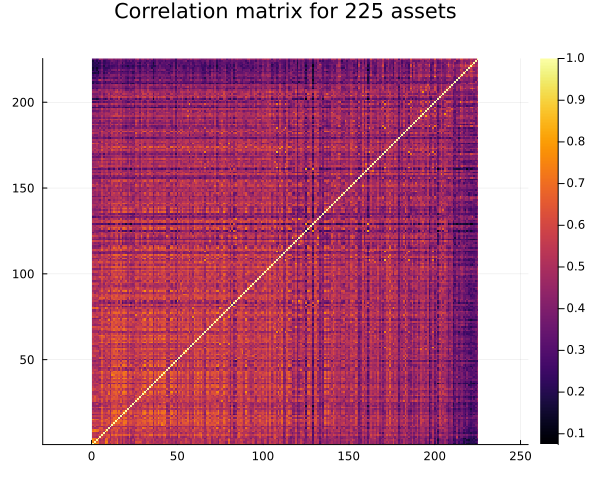

In [5]:
# plot correlation matrix (shows which assets are correlated with which other assets)

# Compute the correlation matrix
D_inv_sqrt = Diagonal(1 ./ sqrt.(diag(Σ)))
corr = D_inv_sqrt * Σ * D_inv_sqrt

# Reorder the matrix
corr_reordered = corr[ix, ix]

# Plot the heatmap
heatmap(
    corr_reordered,
    aspect_ratio = 1,
    colorbar = true,
    title = "Correlation matrix for 225 assets",
    size = (600, 500)
)

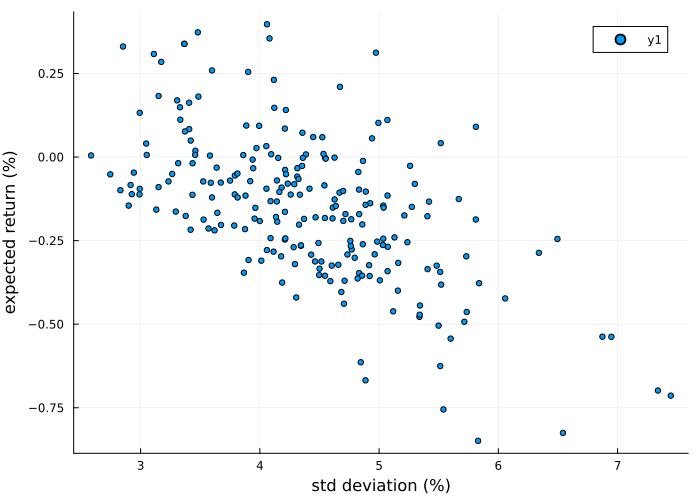

In [6]:
# plot each asset individually
# Compute standard deviations
std_devs = sqrt.(diag(Σ))

# Scatter plot
scatter(
    std_devs,
    μ,
    marker = (:circle, 3),  # blue dots by default
    xlabel = "std deviation (%)",
    ylabel = "expected return (%)",
    title = "",
    size = (700, 500)
)

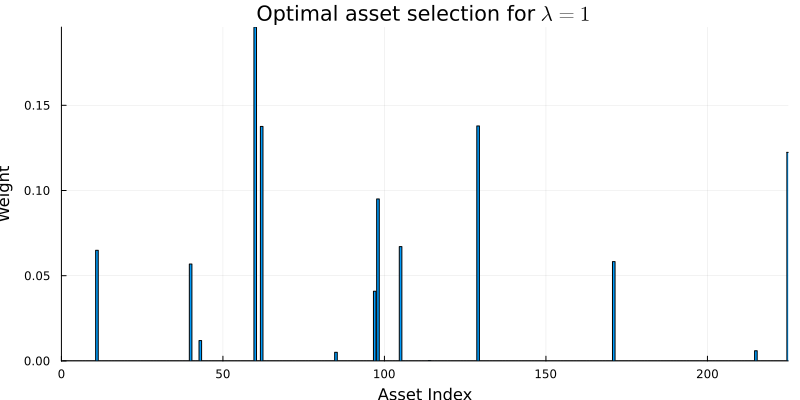

In [8]:
# find optimal portfolio for one particular choice of λ
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
set_silent(m)   # suppress output from the solver
@variable(m, x[1:225] >= 0)
@constraint(m, sum(x) == 1)


λ = 1

@objective(m, Min, -μ'*x + λ*(x'*Σ*x) )
optimize!(m)
xsol = value.(x)
ix1 = findall(xsol .> 1e-4)
ret = dot(μ,xsol)
std = sqrt(dot(xsol,Σ*xsol))

# Bar plot
bar(
    1:225,
    xsol,
    xlim = (0, 225),
    legend = false,
    xlabel = "Asset Index",
    ylabel = "Weight",
    title = "Optimal asset selection for \$\\lambda=1\$",
    size = (800, 400)
)



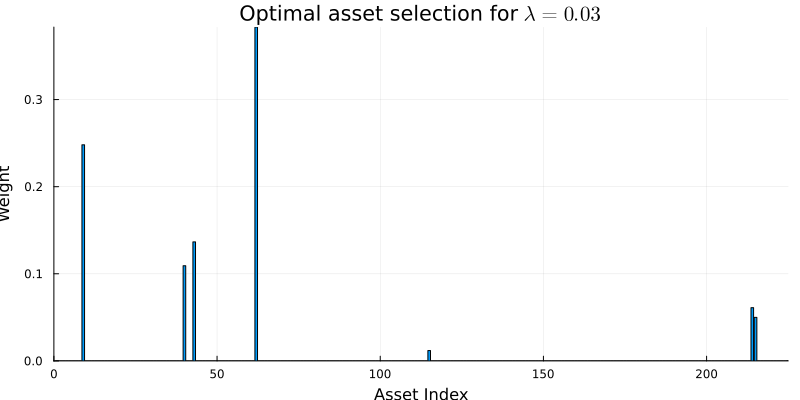

In [10]:

λ = 3e-2

m1 = Model(HiGHS.Optimizer)
set_silent(m1)
@variable(m1, x[1:225] >= 0)
@constraint(m1, sum(x) == 1)
@objective(m1, Min, -dot(μ,x) + λ*dot(x,Σ*x) )
optimize!(m1)
xsol = value.(x)
ix2 = findall(xsol .> 1e-4)
ret = dot(μ,xsol)
std = sqrt(dot(xsol,Σ*xsol))

# Bar plot
bar(
    1:225,
    xsol,
    xlim = (0, 225),
    legend = false,
    xlabel = "Asset Index",
    ylabel = "Weight",
    title = "Optimal asset selection for \$\\lambda=0.03\$",
    size = (800, 400)
)


In [11]:
# compute optimal tradeoff curve (this will take a while to run)
N = 20
ret = zeros(N)
std = zeros(N)
lambda_values = exp10.(range(-3,stop=4,length=N))

for (i,λ) in enumerate(lambda_values)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variable(m, x[1:225] >= 0)
    @constraint(m, sum(x) == 1)
    @objective(m, Min, -dot(μ,x) + λ*dot(x,Σ*x) )
    optimize!(m)
    xsol = value.(x)
    ret[i] = dot(μ,xsol)
    std[i] = sqrt(dot(xsol,Σ*xsol))
end

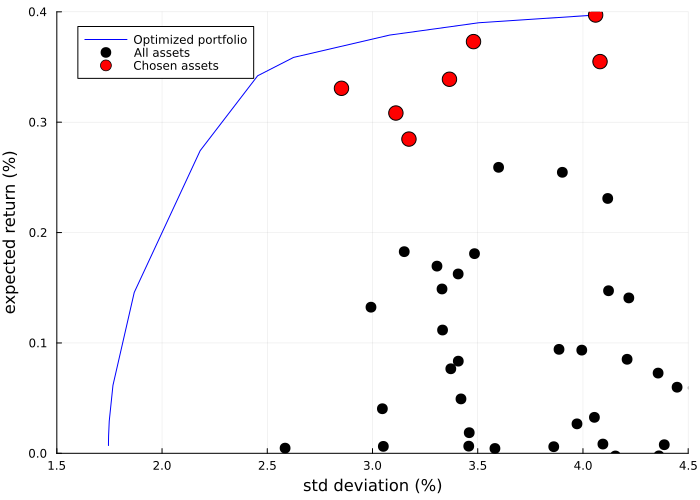

In [16]:
# Plot tradeoff curve
plot(
    [std], [ret],
    seriestype = :path,
    linecolor = :blue,
    label = "Optimized portfolio",
    xlabel = "std deviation (%)",
    ylabel = "expected return (%)",
    xlim = (1.5, 4.5),
    ylim = (0.0, 0.4),
    size = (700, 500)
)

# Plot all assets
scatter!(
    std_devs,
    μ,
    color = :black,
    markersize = 6,
    label = "All assets"
)

# Plot selected "elbow" assets
scatter!(
    std_devs[ix2],
    μ[ix2],
    color = :red,
    markersize = 8,
    label = "Chosen assets"
)